In [11]:
BINANCE_API_KEY='IMNH7QE8m6HktZfrkiru8IrA8uVUFtWYCzt7sqjY8fKARpiuXEqCOEeuTd5pu4aD' #replace with your own api key and secret
BINANCE_API_SECRET='KTkeJY16gMtlgPCI58dyYMjTlmx36M0RuQiAryhU4uSC7gpHlcAdxLZhhrMF4tDx'

In [46]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Function to fetch Binance API data with pagination
def fetch_binance_data(symbol, interval, start_time, end_time, limit=1000):
    url = f"https://api.binance.com/api/v3/klines"
    all_data = []
    while start_time < end_time:
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': start_time,
            'endTime': end_time,
            'limit': limit
        }
        response = requests.get(url, params=params)
        data = response.json()
        if not data:
            break
        all_data.extend(data)
        start_time = data[-1][0] + 1  # Increment start_time to the timestamp just after the last fetched row
        if len(data) < limit:
            break
    df = pd.DataFrame(all_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df.astype(float)

# Example usage
start_time = int((datetime.now() - timedelta(days=10)).timestamp() * 1000)
end_time = int(datetime.now().timestamp() * 1000)
symbol = "BTCUSDT"
interval = "1m"
df = fetch_binance_data(symbol, interval, start_time, end_time)
print(df.head())
print(f"Data retrieved: {len(df)} rows")

                         open      high       low     close    volume  \
timestamp                                                               
2024-05-09 11:47:00  61166.78  61166.79  61140.01  61163.50  23.44504   
2024-05-09 11:48:00  61163.50  61163.50  61130.00  61130.01   7.94662   
2024-05-09 11:49:00  61130.00  61140.00  61130.00  61139.99   4.09293   
2024-05-09 11:50:00  61139.99  61163.49  61120.00  61120.00  32.33498   
2024-05-09 11:51:00  61120.01  61120.01  61107.33  61107.34  14.72270   

                       close_time  quote_asset_volume  number_of_trades  \
timestamp                                                                 
2024-05-09 11:47:00  1.715255e+12        1.433809e+06             663.0   
2024-05-09 11:48:00  1.715255e+12        4.859537e+05             417.0   
2024-05-09 11:49:00  1.715255e+12        2.502174e+05             572.0   
2024-05-09 11:50:00  1.715255e+12        1.976915e+06             829.0   
2024-05-09 11:51:00  1.715256e+12     

In [47]:
def calculate_funding_rate(df):
    df['mid_price'] = (df['high'] + df['low']) / 2
    df['price_change'] = df['mid_price'].pct_change()
    df['funding_rate'] = df['price_change'].rolling(window=1440).mean()  # Assuming funding rate is calculated daily
    return df

# Example usage
df = calculate_funding_rate(df)
print(df[['mid_price', 'funding_rate']].tail())

                     mid_price  funding_rate
timestamp                                   
2024-05-19 11:42:00  67188.780 -1.544943e-07
2024-05-19 11:43:00  67255.265  4.749157e-07
2024-05-19 11:44:00  67300.270  8.872319e-07
2024-05-19 11:45:00  67307.460  1.011012e-06
2024-05-19 11:46:00  67289.950  7.735790e-07


In [48]:
def calculate_implied_funding_rate(spot_price, future_price, time_to_maturity):
    implied_rate = ((future_price / spot_price) - 1) / time_to_maturity
    return implied_rate

# Example usage
spot_price = 50000  # Example spot price
future_price = 50500  # Example future price
time_to_maturity = 30 / 365  # Example time to maturity in years
implied_rate = calculate_implied_funding_rate(spot_price, future_price, time_to_maturity)
print(f"Implied Funding Rate: {implied_rate:.4f}")

Implied Funding Rate: 0.1217


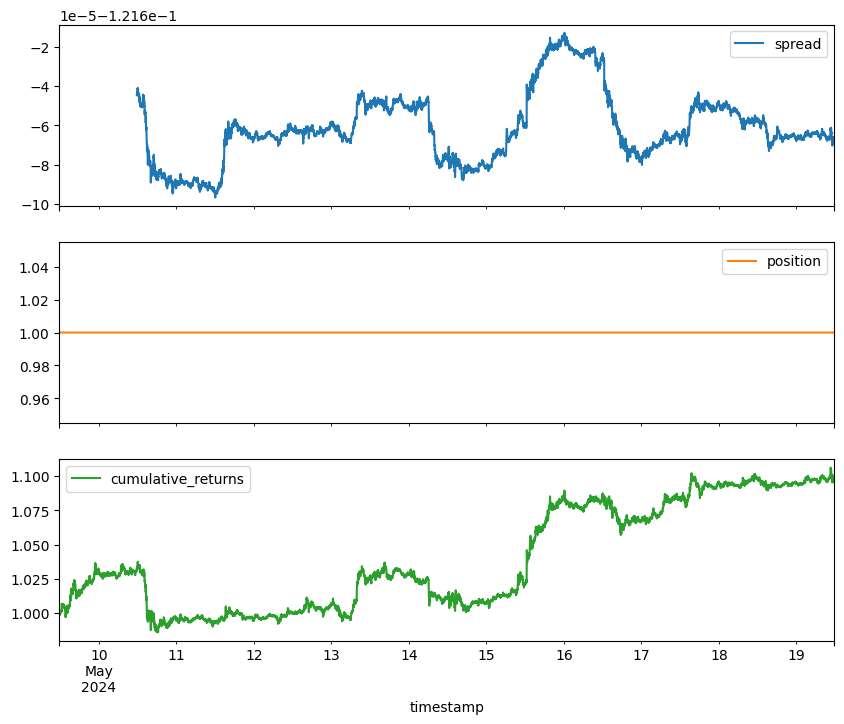

In [49]:
def trading_strategy(df, implied_rate):
    df['spread'] = df['funding_rate'] - implied_rate
    df['position'] = np.where(df['spread'] > 0, -1, 1)  # Short perpetual and long calendar if spread is positive, and vice versa
    df['returns'] = df['position'].shift(1) * df['price_change']
    df['cumulative_returns'] = (1 + df['returns']).cumprod()
    return df

# Example usage
df = trading_strategy(df, implied_rate)
df[['spread', 'position', 'cumulative_returns']].plot(subplots=True, figsize=(10, 8))
plt.show()